# Numerical Optimization and Large Scale Linear Algebra 
# Assignment 3a
## Ilias Katsampalos

In [1]:
import pandas as pd
import numpy as np

Import the dataset

In [2]:
X_train = pd.read_excel('data.xlsx',sheet_name='azip', header=None).T.to_numpy()
X_test = pd.read_excel('data.xlsx',sheet_name='testzip', header=None).T.to_numpy()

y_train = pd.read_excel('data.xlsx',sheet_name='dzip', header=None).T.to_numpy()
y_test = pd.read_excel('data.xlsx',sheet_name='dtest', header=None).T.to_numpy()
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

The following class is implemented based on the SVD classification algorithm provided in "Matrix Methods in Data Mining and Pattern Recognition, Lars Eldén, 2007"

In [3]:
from sklearn.utils.extmath import randomized_svd

class SvdClassifier:
    
    
    def __init__(self, n_components, seed=1234, n_iter=5):
        '''
        Constructor of the classifier
        Parameters:
            n_components (int): The number of the basis vectors to use from U, 
                                extracted from an SVD analysis
            seed (int): Random seed because randomized_svd is used
            n_iter (int): number of iterations to extract the SVD analysis
        '''
        self.n_components = n_components
        self.seed = seed
        self.n_iter = n_iter
        self.principal_components = {}
        self.singular_values = {}
    
    
    def fit(self, X_train, y_train):
        '''
        For each digit extract n_components basis vectors
        and store them in a dictionary
        
        Parameters:
            X_train (np.array): array (n, m) where n = number of samples
                                and m = pixels of the digit image stacked as a single row
            y_train (np.array): vector (n) with the actual digit
        '''
        for i in range(10):
            #select samples of digit i
            digit_i_X_train = X_train[y_train==i,:]
            #calculate the SVD
            U, Sigma, VT = randomized_svd(digit_i_X_train.T
                                          ,n_components=self.n_components
                                          ,n_iter=self.n_iter
                                          ,random_state=self.seed)
            #store a dictionary with the components U
            #and the singular values Sigma for each digit
            self.principal_components[i] = U
            self.singular_values[i] = Sigma
    
    
    def row_l2_norm(self, A):
        '''
        Calculated the l2 of each row of a matrix
        
        Parameters:
            A (np.array): array (n,m) where n=number of samples
                          and m is the vector of attributes of each row
        Returns:
            row_l2_norm (np.array): vector (n) containing the l2 norm
                                    of each row in A
        '''
        row_l2_norm = np.sum(np.abs(A)**2 ,axis=-1)**(1./2)
        return row_l2_norm
    
    
    def predict(self, X, n_components, return_norms=False):
        '''
        For each tuple in X, classify to the class with the
        smallest l2 norm
        
        Parameters:
            X (np.array): samples to classify
            n_components (int): number of basis vectors to use from U
                in order to recostruct the digit
            return_norms (bool) : if true return the l2 norms instead of argmax
                          
        Returns:
            np.argmin(res,axis=1): the class (digit) with the smallest
                                    l2 norm
        '''
        #initialize an array for predictions
        res = np.zeros(shape=(X.shape[0],10))
        #for each digit
        for i in range(10):
            #retrive the principal components from U
            U = self.principal_components[i][:,:n_components]
            #the approximation is X (n,m) @ U (m,self.components) @ U.T (self.components, m)
            approx = X @ U @ U.T
            #calculate the reconstruction for ith digit using l2norm and store in ith column
            res[:,i] = self.row_l2_norm(X - approx) / self.row_l2_norm(X)
        
        if return_norms:
            return res
        else:
            return np.argmin(res,axis=1)
    
    
    def predict_with_diff_bases(self, X, component_dict):
        '''
        For each tuple in X, classify to the class with the
        smallest l2 norm
        
        Parameters:
            X (np.array): samples to classify
            component_dict (dict): dictionary ('digit' : 'n_components')
                               in case different number of components
                               is used for different digit classes
                          
        Returns:
            np.argmin(res,axis=1): the class (digit) with the smallest
                                    l2 norm
        '''
        res = np.zeros(shape=(X.shape[0],10))
        for i in range(10):
            #choose the components for the ith digit
            n_components = component_dict[i]
            #retrive component_dict[i] basis vectors for the ith digit
            U = self.principal_components[i][:,:n_components]
            #the approximation is X (n,m) @ U (m,self.components) @ U.T (self.components, m)
            approx = X @ U @ U.T
            #calculate the reconstruction for ith digit using l2norm and store in ith column
            res[:,i] = self.row_l2_norm(X - approx) / self.row_l2_norm(X)
    
        return np.argmin(res,axis=1)
    
    
    def row_softmax(self, A):
        '''
        Calculate the softmax accross a row of a matrix
        Parameters:
            A (np.array): array n, m where n=number of samples and m=number of features
        
        Returns
            res (np.array): array n, m where n=number of samples and m=number of features
                            and each row is a probability distribution
        '''
        num = np.exp(A) 
        denom = np.sum(np.exp(A), axis=1).reshape(-1,1)
        res = num / denom
        return res
    
    
    def predict_opt(self, X, threshold=0.5, n_components=None, return_stats=False):
        '''
        2-stage SVD classification algorithm. Classify digits using 1 basis vector
        if P(C=c) > threshold. For the rest of the digits use n_components
        
        Parameters:
            X (np.array): array n, m where n=number of samples and m=number of features
            threshold (float): threshold above which a sample is classifier on stage 1
            n_components (int): number of basis vectors to use for samples passed to stage 2
            return_stats (bool): if true return also the % of samples passed to stage 2
            
        Returns:
            predicted class (np.array): array (n,) with predicted classes. If return_stats=True
                                        return also the % of samples passed to stage 2
        '''
        if n_components == None:
            n_components = self.n_components
        
        #for each sample in X get the l2 norms for each digit via self.predict, using only 1 basis vector
        res = self.predict(X, n_components=1, return_norms=True)
        #pass each row of X through a softmax to get a class distribution
        probs = self.row_softmax(1/res)
        #get the indexes of samples where the max probability is greater or equal than the threshold
        passed_indexes = np.where(probs.max(axis=1) >= threshold)
        
        #get the indexes for stage 2 (<threshold)
        follow_up_indexes = np.where(probs.max(axis=1) < threshold)
        #get the l2 norms for each sample and for each digit
        follow_up_res = self.predict(X[follow_up_indexes], n_components=n_components, return_norms=True)
        #pass each row of X through a softmax to get a class distribution
        follow_up_probs = self.row_softmax(1/follow_up_res)
        #in the original array, update the probability distributionf or stage-2 indexes
        probs[follow_up_indexes] = follow_up_probs
        
        if return_stats:
            return np.argmax(probs, axis=1), len(follow_up_indexes[0]) / len(X)
        else:
            return np.argmax(probs, axis=1)

# 1. Accuracy

In [25]:
COMPONENTS = 20
svd_clf = SvdClassifier(COMPONENTS)
svd_clf.fit(X_train, y_train)

In [26]:
from sklearn.metrics import accuracy_score

accuracies_test = []
accuracies_train = []
for i in range(1,COMPONENTS+1):
    predictions_train = svd_clf.predict(X_train, i)
    accuracies_train.append(accuracy_score(y_train, predictions_train))
    
    predictions_test = svd_clf.predict(X_test, i)
    accuracies_test.append(accuracy_score(y_test, predictions_test))

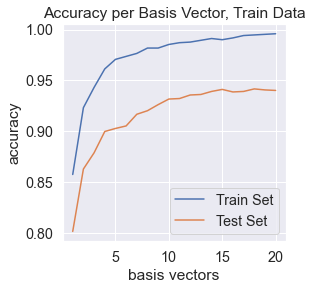

max accuracy 0.9958992384299942 using 19 basis vectors on the Train Set
max accuracy 0.9417040358744395 using 17 basis vectors on the Test Set


In [27]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(palette='deep', color_codes=True, font_scale=1.3)

fig, axs = plt.subplots(figsize=(4,4))
sns.lineplot(x=list(range(1,COMPONENTS+1)), y=accuracies_train, ax=axs, label='Train Set')
sns.lineplot(x=list(range(1,COMPONENTS+1)), y=accuracies_test, ax=axs, label='Test Set')
axs.set_xlabel('basis vectors')
axs.set_ylabel('accuracy')
axs.title.set_text('Accuracy per Basis Vector, Train Data')
plt.legend()
plt.show()
print(f'max accuracy {max(accuracies_train)} using {np.argmax(accuracies_train)} basis vectors on the Train Set')
print(f'max accuracy {max(accuracies_test)} using {np.argmax(accuracies_test)} basis vectors on the Test Set')

# 2. f1-score per class

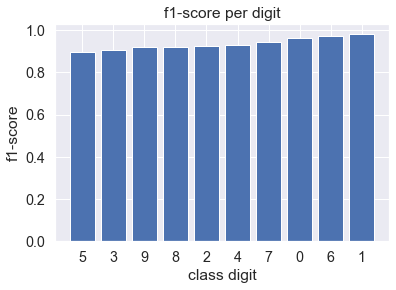

In [28]:
from sklearn.metrics import classification_report
re = pd.DataFrame(classification_report(y_test, predictions_test, output_dict=True))
re = re.iloc[:,:10].T.sort_values(by='f1-score')
plt.bar(re.index, re['f1-score'])
plt.xlabel('class digit')
plt.ylabel('f1-score')
plt.title('f1-score per digit')
plt.show()

We observe that digits 5, 3 and 9 do not have so high f1 scores. We can drill into the confusion matrix and check their missclassifications.

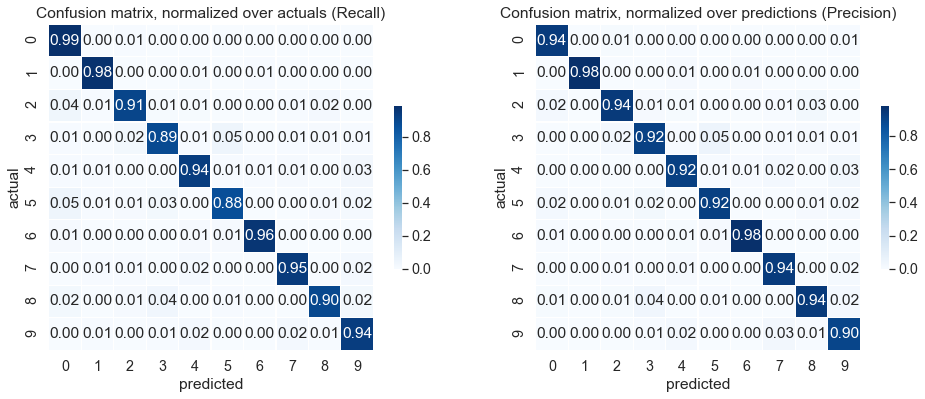

In [29]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
cm_pred_norm = confusion_matrix(y_test, predictions_test,  normalize='pred')
cm_actual_norm = confusion_matrix(y_test, predictions_test,  normalize='true')
fig, axs = plt.subplots(1,2, figsize=(16,6))
sns.heatmap(
    cm_actual_norm
    ,annot=True
    ,cmap='Blues'
    ,linewidths=0.1
    ,xticklabels= list(range(10))
    ,yticklabels = list(range(10))
    ,ax=axs[0]
    ,fmt = '.2f'
    ,cbar_kws = {'shrink':0.5}
)

axs[0].set_xlabel('predicted')
axs[0].set_ylabel('actual')
axs[0].title.set_text('Confusion matrix, normalized over actuals (Recall)')

sns.heatmap(
    cm_pred_norm
    ,annot=True
    ,cmap='Blues'
    ,linewidths=0.1
    ,xticklabels= list(range(10))
    ,yticklabels = list(range(10))
    ,ax=axs[1]
    ,fmt = '.2f'
    ,cbar_kws = {'shrink':0.5}
)

axs[1].set_xlabel('predicted')
axs[1].set_ylabel('actual')
axs[1].title.set_text('Confusion matrix, normalized over predictions (Precision)')

Observations about the digits 5, 3 and 9:

* Actual `5` missclassified as `0`, `3` and `9`. Wrongly predcited `5` are mostly `3`
* Actual `3` missclassified as `2` and `5`. Wrongly predcited `3` which are mostly `8`
* `9` in terms of recall has a good score. Precision-wise, lots of predicted `8`, `7` and `4` are actually `9`

Next we will look into some missclassifications. First we need to define a function for plotting the images.

In [19]:
def digit_imshow(x):
    x=(x-np.min(x)*np.ones(shape=x.shape)) 
    x = (20/np.max(x))*x
    plt.imshow(x, cmap='binary')

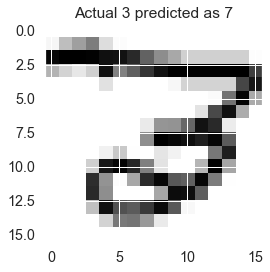

In [20]:
miss_filter = np.where((y_test==3) & (y_test!=predictions_test))
miss = X_test[miss_filter].reshape(-1,16,16)
predicted_as = predictions_test[miss_filter]
digit_imshow(miss[1,:,:])
plt.title(f'Actual 3 predicted as {predicted_as[1]}')
plt.show()

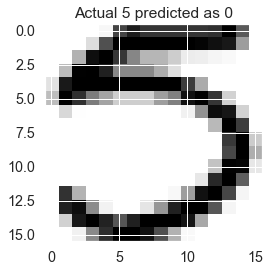

In [23]:
miss_filter = np.where((y_test==5) & (y_test!=predictions_test))
miss = X_test[miss_filter].reshape(-1,16,16)
predicted_as = predictions_test[miss_filter]
digit_imshow(miss[0,:,:])
plt.title(f'Actual 5 predicted as {predicted_as[0]}')
plt.show()

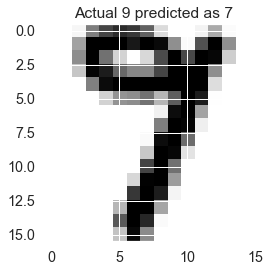

In [24]:
miss_filter = np.where((y_test==9) & (y_test!=predictions_test))
miss = X_test[miss_filter].reshape(-1,16,16)
predicted_as = predictions_test[miss_filter]
digit_imshow(miss[0,:,:])
plt.title(f'Actual 9 predicted as {predicted_as[0]}')
plt.show()

# 3. Singular Values
First we will plot the first 20 singular values for each digit.

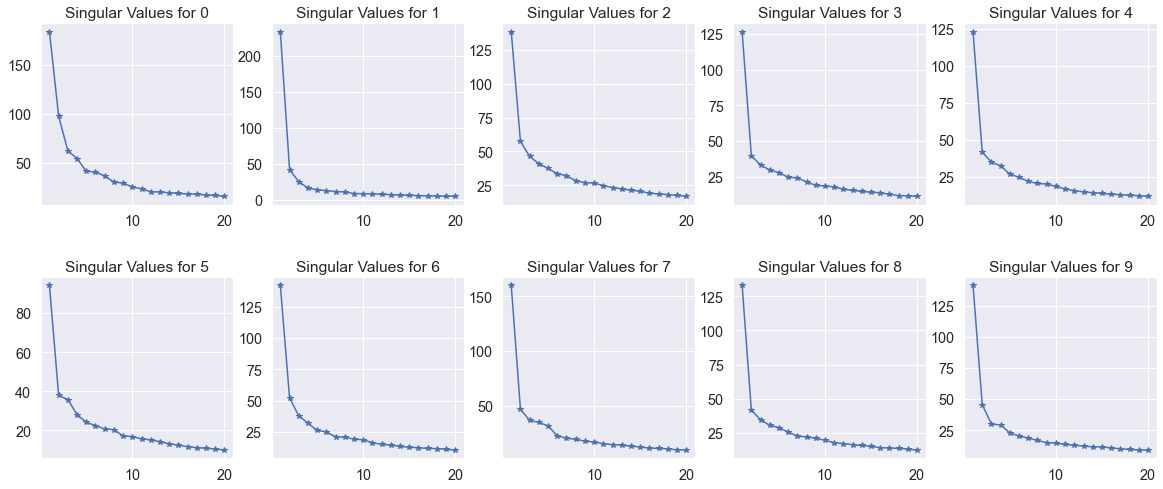

In [30]:
fig, axs = plt.subplots(2,5, figsize=(20,8))
plt.subplots_adjust(hspace=0.4)
axs = axs.ravel()
for i in range(10):
    axs[i].plot(list(range(1, COMPONENTS+1)), svd_clf.singular_values[i], marker='*')
    axs[i].title.set_text(f'Singular Values for {i}')

We observe that for the digits `1`, the first singular value is quite larger than the rest.
However, since the singular values have different scales, it would make sense to bring them on the same scale
in order to observe the differences between the singular values of each class in a cleaner way.

In [31]:
def change_scale(new_from, new_to, X):
    return (X - X.min()) / (X.max() - X.min()) * (new_to - new_from) + new_from

mapped_singular_values = {}
for i in range(10):
    mapped = change_scale(0,1,svd_clf.singular_values[i])
    mapped_singular_values[i] = mapped

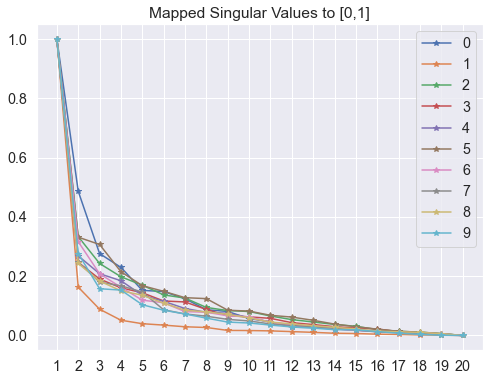

In [32]:
fig, axs = plt.subplots(figsize=(8,6))
for i in range(10):
    plt.plot(list(range(1, COMPONENTS+1)), mapped_singular_values[i], label=i, marker='*')
plt.legend()
plt.xticks(range(1,COMPONENTS+1))
plt.title('Mapped Singular Values to [0,1]')
plt.show()

Based on the depiction above, we will experiment with 2 classes, `1` and `9`. This is interesting since the class `1` had the highest accuarcy whereas `9` one of the lowest accuracies.

## 3.1 Experimenting with class 1

In [33]:
from sklearn.metrics import f1_score
#dictionary with key the digit class and value the number of left singular vectors.
comp = {x:COMPONENTS for x in list(range(10))}
accuracies = []
f1s = []
for i in range(1,21):
    #adjust only the components of class 1 from using 1 to 20
    comp[1] = i
    predictions = svd_clf.predict_with_diff_bases(X_test, comp)
    accuracies.append(accuracy_score(y_test, predictions))
    f1s.append(f1_score(y_test, predictions, average='weighted'))

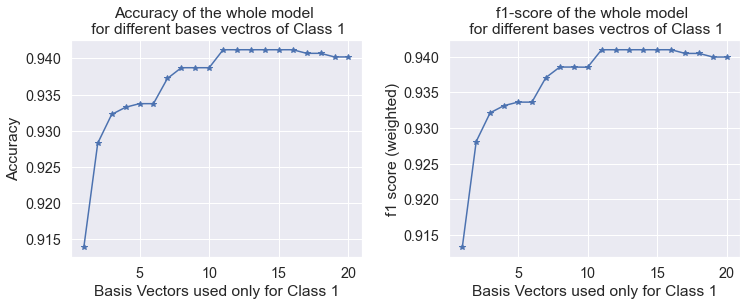

In [38]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
axs[0].plot(list(range(1,21)), accuracies, marker='*')
axs[0].set_xlabel('Basis Vectors used only for Class 1')
axs[0].set_ylabel('Accuracy')
axs[0].title.set_text('Accuracy of the whole model \n for different bases vectros of Class 1')

axs[1].plot(list(range(1,21)), f1s, marker='*')
axs[1].set_xlabel('Basis Vectors used only for Class 1')
axs[1].set_ylabel('f1 score (weighted)')
axs[1].title.set_text('f1-score of the whole model \n for different bases vectros of Class 1')

In [35]:
print(f' Using higher than {np.argmax(accuracies)} basis vectors for only the digit 1, deteriorates the performance of the whole model')

 Using higher than 10 basis vectors for only the digit 1, deteriorates the performance of the whole model


## 3.2 Experimenting with class 9

In [39]:
from sklearn.metrics import f1_score
comp = {x:COMPONENTS for x in list(range(10))}
accuracies = []
f1s = []
for i in range(1,21):
    #adjust only the components of class 9 from using 1 to 20
    comp[9] = i
    predictions = svd_clf.predict_with_diff_bases(X_test, comp)
    accuracies.append(accuracy_score(y_test, predictions))
    f1s.append(f1_score(y_test, predictions, average='weighted'))

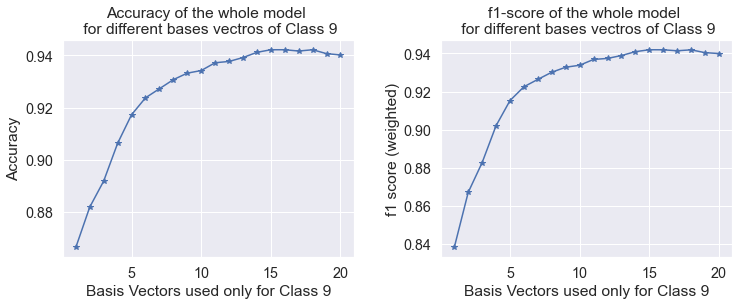

In [42]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
axs[0].plot(list(range(1,21)), accuracies, marker='*')
axs[0].set_xlabel('Basis Vectors used only for Class 9')
axs[0].set_ylabel('Accuracy')
axs[0].title.set_text('Accuracy of the whole model \n for different bases vectros of Class 9')

axs[1].plot(list(range(1,21)), f1s, marker='*')
axs[1].set_xlabel('Basis Vectors used only for Class 9')
axs[1].set_ylabel('f1 score (weighted)')
axs[1].title.set_text('f1-score of the whole model \n for different bases vectros of Class 9')

In [10]:
print(f' Using higher than {np.argmax(accuracies)} bases vectors for only the digit 9, deteriorates the performance of the model')

 Using higher than 14 bases vectors for only the digit 9, deteriorates the performance of the model


In both classes we observed a deterioration of the accuracy score of the whole classification algorithm when using a high number of basis vectors for the digits `1` and `9`. This is an indication of overfitting, since the more vectors of U are used for the classification, the more those components capture the noise of the dataset.

# Optional Task
## 1. 2-stage classification algorithm

For this task we will implement a 2-stage SVD classification algorithm. The steps of the algorithm are as follows:

* For each sample in the test set, we calculate the residuals using the first basis vector from U (obtained from the SVD) for each digit class
* For each sample in the test set, we pass the **inverse** of the residuals through the softmax function, in order to obtain a probability distribution across the digit classes.
* If the max probability of each row (each row is a distribution of class digits) is above a threshold which is user-defined, we assume that the sample is classified
* For the rest of the samples, we resume the original classification algorithm, passing again the inverse of the residuals through a softmax
* Finally, for each sample in the test set we return the argmax

Since now the threshold `t` is a hyperparameter of the classification algorithm, we will need to tune it. For that reason, we will hold out a part of the test set as our validation set.

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

In [44]:
COMPONENTS = 20
svd_clf = SvdClassifier(COMPONENTS)
svd_clf.fit(X_train, y_train)

We will run the classification with different values of the threshold `t`.

In [45]:
accuracies = []
not_passed_first_time = []
thresholds = []
#evaluate the classification accuracy using different thresholds for the first stage.
for t in np.arange(0,0.5, 0.005):
    predictions, not_passed = svd_clf.predict_opt(X_val, threshold=t, n_components=COMPONENTS, return_stats=True)
    accuracies.append(accuracy_score(y_val, predictions))
    thresholds.append(t)
    not_passed_first_time.append(not_passed)
vall_accuracy_full_svd = accuracy_score(y_val, svd_clf.predict(X_val, n_components=COMPONENTS))

We will plot the results.

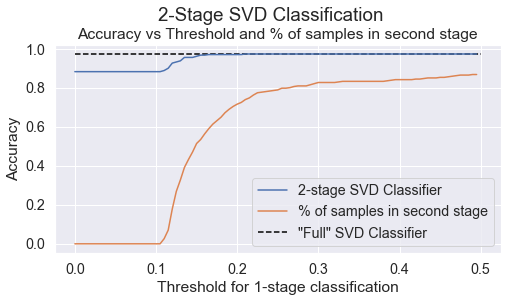

In [46]:
fig, axs = plt.subplots(figsize=(8,4))
fig.subplots_adjust(top=0.85)
plt.plot(thresholds, accuracies, label='2-stage SVD Classifier')
plt.plot(thresholds, not_passed_first_time, label = '% of samples in second stage')
plt.hlines(vall_accuracy_full_svd,0,0.5, color='black', linestyle='dashed', label='"Full" SVD Classifier')
plt.legend()
plt.xlabel('Threshold for 1-stage classification')
plt.ylabel('Accuracy')
plt.suptitle('2-Stage SVD Classification')
plt.title('Accuracy vs Threshold and % of samples in second stage')
plt.show()

Observations:

* The higher the threshold for the first stage filtering the higher the accuracy (1)
* The 2-stage SVD classifier seems to reach the same validation accuracy as the "full" SVD classifier (2)
* For a threshold of 0.2, ~70% of the digits need to pass onto the second stage which is costly (3)

Based on the validation data, we have the following constrained minimization problem:

`min(Threshold) s.t Accuracy(2-stage SVD) >= Accuracy(Full Stage SVD)`

That is to choose the minimum threshold, which minimizes the number of records passing onto the second stage and at the same time, the accuracy of the 2-stage SVD should not be compromised.

We can create a dataframe with the validation results.

In [48]:
df = pd.DataFrame({'threshold':thresholds, 'accuracy':accuracies, 'not_passed_first_time':not_passed_first_time})
df.sample(10)

,threshold,accuracy,not_passed_first_time
75,0.375,0.973684,0.833333
36,0.180,0.970760,0.649123
32,0.160,0.967836,0.564327
86,0.430,0.973684,0.847953
73,0.365,0.973684,0.833333
71,0.355,0.973684,0.833333
61,0.305,0.973684,0.827485
7,0.035,0.883041,0.000000
47,0.235,0.973684,0.780702
24,0.120,0.926901,0.178363


The optimum threshold is the minimum value where the validation accuracy of the 2-stage is equal or greater than the validation accuracy of the "full" SVD.

In [49]:
opt_threshold = df[df['accuracy'] >= vall_accuracy_full_svd].threshold.min()
print(f'optimum thershold for 2-stage: {opt_threshold}')

optimum thershold for 2-stage: 0.21


In order to measure the performance of the 2-stage, we need to measure it on the test data.

In [50]:
#accuracy of the test set of the full svd
full_svd_test = accuracy_score(y_test, svd_clf.predict(X_test, n_components=COMPONENTS))

#accuracy of the test set of the 2-stage SVD
opt_svd_predictions_test, passed =  svd_clf.predict_opt(X_test, threshold=opt_threshold, n_components=COMPONENTS,  return_stats=True)
opt_svd_test = accuracy_score(y_test, opt_svd_predictions_test)

print('Test Accuracy Full SVD:', full_svd_test)
print('Test Accuracy 2-Stage SVD:', opt_svd_test)
print(f'% of Samples passed to Second Stage {passed*100:.2f}')

Test Accuracy Full SVD: 0.9397110114598903
Test Accuracy 2-Stage SVD: 0.9397110114598903
% of Samples passed to Second Stage 81.86


We managed to reach the same accuracy, on the test set, as the full SVD where ~20% of the testing samples were classified in the first pass.
As shown above, compromising the accuracy could lead to more digits classified on the first stage but that is a decision which needs to take the application domain into consideration.